# Общее конфигурирование

In [ ]:
from agentslab.core.configs import GeneralConfigs
from agentslab.core.seeding import set_global_seed
import torch
import torchrl

# ENV_ID = "InvertedDoublePendulum-v4"
ENV_ID = "CartPole-v1"
# ENV_ID = "InvertedPendulum-v5"
# ENV_ID = "Pendulum-v1"

genCfg = GeneralConfigs(
    algo_name= "PPO",
    env_id = ENV_ID,
    device = "auto",
    seed = 42,
    deterministic = True,
)

set_global_seed(genCfg.seed, deterministic=genCfg.deterministic)

torch.__version__, torchrl.__version__, genCfg.device

('2.7.0+cu128', '0.0.0+unknown', device(type='cuda'))

# Генерация путей

In [ ]:
from agentslab.core.paths import restore_paths, generate_paths

pathCfg = generate_paths(genCfg.algo_name, genCfg.env_id)
# pathCfg = restore_paths("PPO_navigation_20250831_233925")
pathCfg.run_name

'PPO_CartPole-v1_20260126_011655'

# Создание среды

In [4]:
from agentslab.envs.env_configs import GymEnvConfig
from agentslab.envs.gym_envs import make_gym_env
from torchrl.envs.utils import check_env_specs

env_cfg = GymEnvConfig(
    env_id=ENV_ID,
    device=genCfg.device,      # device уже резолвится в genCfg
    seed=genCfg.seed,
    init_norm_iter=3000,
    obs_keys=["observation"],  # ключи для нормализации (и/или явный выбор obs-ключей)
    # env_kwargs={}            # при необходимости: доп. параметры для gymnasium.make()
)

env = make_gym_env(env_cfg)
check_env_specs(env)

# from agentslab.utils.specs import print_specs
# print_specs(env)

2026-01-26 01:20:31,102 [torchrl][INFO]    check_env_specs succeeded! [END]


# Создание актора и критика

In [5]:
from agentslab.networks.networks import MLPConfig, build_mlp
from agentslab.policies.policy import build_stochastic_actor, get_num_action_logits
from torchrl.modules import ValueOperator
from agentslab.envs.gym_envs import is_acts_discrete

# Достаём размерности
obs_dim = env.observation_spec["observation"].shape[-1]
num_logits = get_num_action_logits(env.action_spec)

# если действия непрерывные, то число выходов нейросети нужно удвоить:
# coef = 1 if is_acts_discrete(env.action_spec) else 2

coeff = 1 if is_acts_discrete(env.action_spec) else 2  # для Box удваиваем параметры (loc, scale)
out_dim = num_logits * coeff

mlp_cfg = MLPConfig(
        in_dim = obs_dim, 
        out_dim = num_logits * coeff,
        hidden_sizes = (256, 256),
        activation = "tanh",
        layer_norm = False
)

actor_network = build_mlp(mlp_cfg)
actor = build_stochastic_actor(actor_network, env.action_spec)

mlp_cfg.out_dim = 1
critic_network = build_mlp(mlp_cfg)
critic = ValueOperator(module=critic_network, in_keys=["observation"])
actor.to(genCfg.device), critic.to(genCfg.device)

obs_dim, num_logits, is_acts_discrete(env.action_spec)

(4, 2, True)

# Конфигурирование PPO

In [6]:
from agentslab.runners.trainers import PPOConfigs

ppoCfg = PPOConfigs(
    actor = actor,
    critic = critic,
    clip_epsilon = 0.2,
    entropy_eps = 1e-4,
    critic_coeff = 1.0,
    loss_critic_type = "smooth_l1",
    # GAE params:
    gamma = 0.99,
    lmbda = 0.95,
    # sampling and training params:
    frames_per_batch = 1000,
    total_frames = 10_000,
    num_epochs = 10,
    sub_batch_size = 64,
    eval_every = 5,
    lr = 3e-4,
    max_grad_norm = 1.0,
)

# Loss Function + GAE Estimator

In [6]:
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
import torch

advantage_module = GAE(
    gamma=ppoCfg.gamma, lmbda=ppoCfg.lmbda, value_network=critic, average_gae=True
)

loss_module = ClipPPOLoss(
    actor_network=actor,
    critic_network=critic,
    clip_epsilon=ppoCfg.clip_epsilon,
    entropy_bonus=bool(ppoCfg.entropy_eps),
    entropy_coeff=ppoCfg.entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coeff=ppoCfg.critic_coeff,
    loss_critic_type=ppoCfg.loss_critic_type,
)

optim = torch.optim.Adam(loss_module.parameters(), ppoCfg.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optim, 
    T_max=ppoCfg.total_frames // ppoCfg.frames_per_batch, 
    eta_min=0.0
)

# Checkpointers

In [7]:
from agentslab.utils.checkpointers import CheckpointManager

statefuls = {
    "policy": actor,                # nn.Module
    "critic": critic, 
    "optimizer": optim,             # torch.optim.Optimizer
    "scheduler": scheduler,         # lr scheduler
    # "replay": replay_buffer,        # TorchRL ReplayBuffer (если используете)
}

chkptr = CheckpointManager(
    ckpt_dir=pathCfg.ckpt_dir,               # .../runs/<run_name>/checkpoints
    statefuls=statefuls,
    meta={
        "algo": genCfg.algo_name, 
        "env": genCfg.env_id, 
        "seed": genCfg.seed},
    best_metric_key="return_mean",           # метрика из eval_policy
    mode="max",
    max_to_keep=5,
    map_location=genCfg.device,
)

chkptr.register_obs_norms_from_env(env, prefix="obs_norm")

1

# Loggers

In [8]:
from agentslab.utils.loggers import CSVLogger, TBLogger

csv_logger_train = CSVLogger(pathCfg.csv_train)
csv_logger_eval = CSVLogger(pathCfg.csv_eval)
tb_logger_train = TBLogger(pathCfg.tb_train)
tb_logger_eval = TBLogger(pathCfg.tb_eval)

# Collector

In [9]:
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

collector = SyncDataCollector(
    create_env_fn=env,
    policy=ppoCfg.actor,
    frames_per_batch=ppoCfg.frames_per_batch,
    total_frames=ppoCfg.total_frames,
    split_trajs=False,
    device=genCfg.device,
)
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=ppoCfg.frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

# Training Loop

In [10]:
def get_start_step():
    import pandas as pd 
    try: 
        data = pd.read_csv(pathCfg.csv_train)
        start_step = int(data["step"].iat[-1])
    except:
        start_step = 0
    print(f"{start_step = }")
    return start_step

print(f"""Для отслеживания динамики в Tensorboard, выполните в терминале
tensorboard --logdir {pathCfg.tb_train}""")

Для отслеживания динамики в Tensorboard, выполните в терминале
tensorboard --logdir C:\Users\werna\Documents\GitHub\AgentsLab\runs\PPO_CartPole-v1_20250827_164807\tb_logs\train


In [11]:
from agentslab.utils.misc import progress_bar
from agentslab.runners.evals import eval_policy
import winsound

start_step = get_start_step()   # стартовое значение шага

log_dict = dict()
passed_frames = 0

with progress_bar(ppoCfg.total_frames, desc="PPO") as pbar:
    # --------------------------------------------------------------
    # Итерируемся по коллекторам, пока не наберём нужное число шагов
    for i, tensordict_data in enumerate(collector):
        # Учимся на партии данных
        for _ in range(ppoCfg.num_epochs):
            # Advantage для PPO пересчитываем на каждом проходе
            advantage_module(tensordict_data)
            data_view = tensordict_data.reshape(-1)
            replay_buffer.extend(data_view.cpu())
            for _ in range(ppoCfg.frames_per_batch // ppoCfg.sub_batch_size):
                subdata = replay_buffer.sample(ppoCfg.sub_batch_size)
                loss_vals = loss_module(subdata.to(genCfg.device))
                loss_value = (
                      loss_vals["loss_objective"] 
                    + loss_vals["loss_critic"] 
                    + loss_vals["loss_entropy"]
                )
                # Оптимизация
                loss_value.backward()
                torch.nn.utils.clip_grad_norm_(
                    loss_module.parameters(), ppoCfg.max_grad_norm
                )
                optim.step()
                optim.zero_grad()
        scheduler.step()            # Шаг LR-планировщика

        # --------------------------------------------------------------

        # Извлекаем метрики
        batch_frames = int(tensordict_data.get(("next", "reward")).numel())
        passed_frames = min(passed_frames + batch_frames, ppoCfg.total_frames)
        log_dict['step'] = start_step + passed_frames
        log_dict["reward"] = tensordict_data["next", "reward"].mean().item()
        log_dict["step_count"] = tensordict_data["step_count"].max().item()
        log_dict["lr"] = optim.param_groups[0]["lr"]
        
        # Логгируем метрики
        csv_logger_train.log(log_dict)                          # CSV
        tb_logger_train.log(log_dict, step=log_dict["step"])    # TensorBoard

        # Обновляем описание прогресс-бара
        pbar.set_postfix(
            {"avg_reward": f"{log_dict["reward"]: .4f}",
             "max_step": int(log_dict["step_count"]),
             "lr": f"{log_dict["lr"]: .4e}"},
            refresh=False
        )

        # корректное число фреймов в партии

        if batch_frames > 0:
            remaining = pbar.total - pbar.n
            pbar.update(min(batch_frames, remaining))

        # -----------------------------------------------------------
        # Оценка после каждых eval_every партий
        if (i + 1) % ppoCfg.eval_every == 0:
            eval_results = eval_policy(env, actor, episodes=5, progress=False)
            # pbar.write не ломает отрисовку прогресс-бара
            # pbar.write(
            #     f'eval: avg reward = {eval_results["return_mean"]}, '
            #     f'max episode length = {eval_results["max_episode_length"]}'
            # )
            eval_results["step"] = log_dict['step']
            csv_logger_eval.log(eval_results)                          # CSV
            tb_logger_eval.log(eval_results, step=log_dict['step'])    # TensorBoard

            chkptr.save(
                step=log_dict["step"],
                metrics=eval_results,                # содержит return_mean → best.pt обновится
                make_step_snapshot=True,
                additional={"global_step": log_dict["step"]}  # опционально
            )

winsound.PlaySound('Notification.Looping.Alarm6', winsound.SND_ALIAS)

start_step = 10000


PPO:   0%|          | 0.00/10.0k [00:00<?, ?frames/s]

# Graphs

In [12]:
import pandas as pd 
pd.read_csv(pathCfg.csv_train).columns

Index(['step', 'reward', 'step_count', 'lr'], dtype='object')

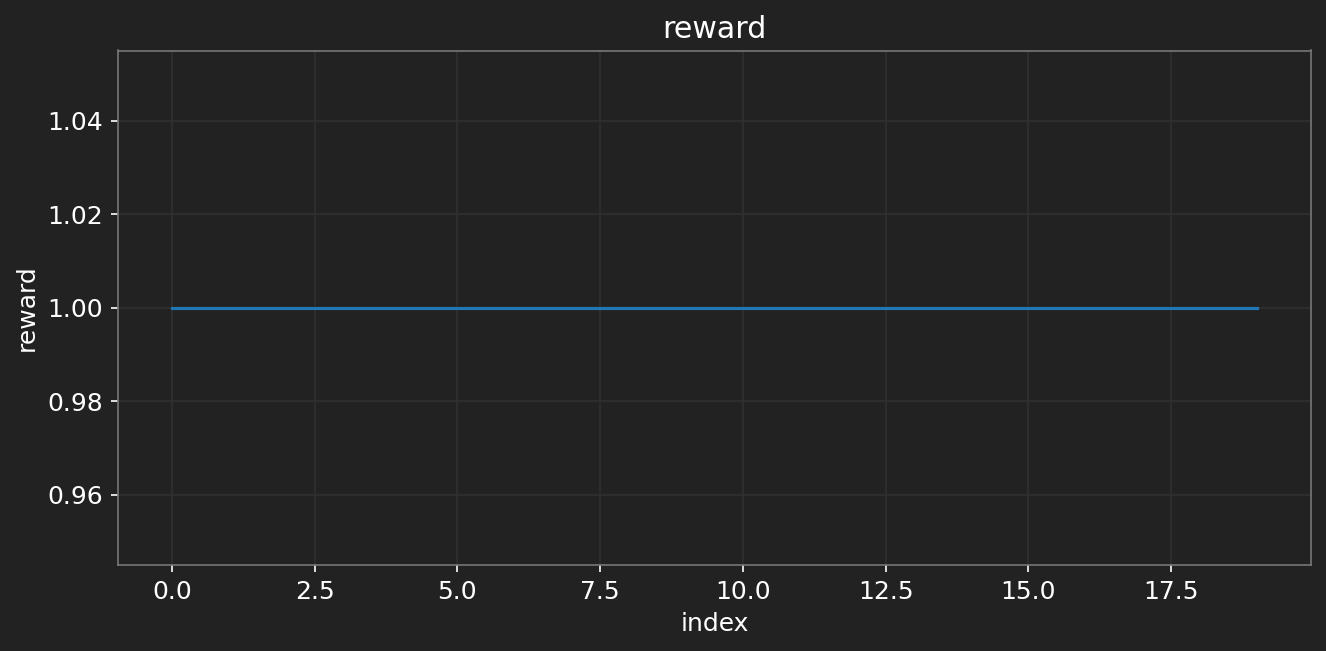

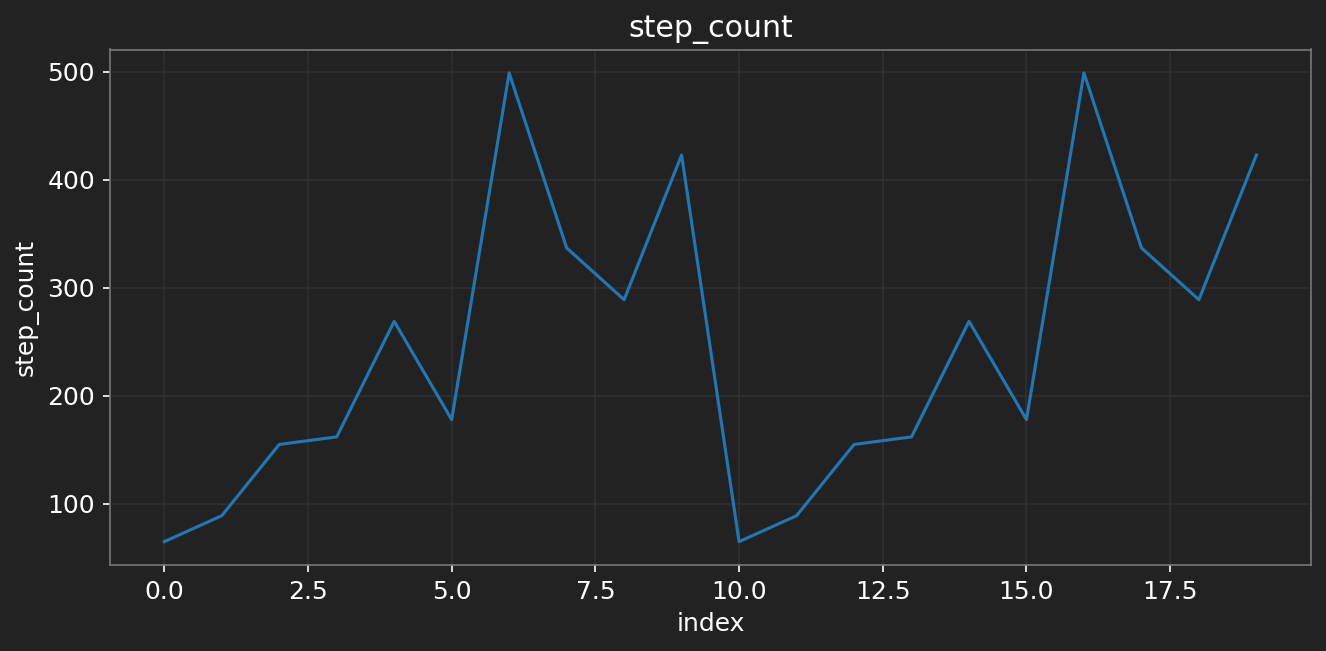

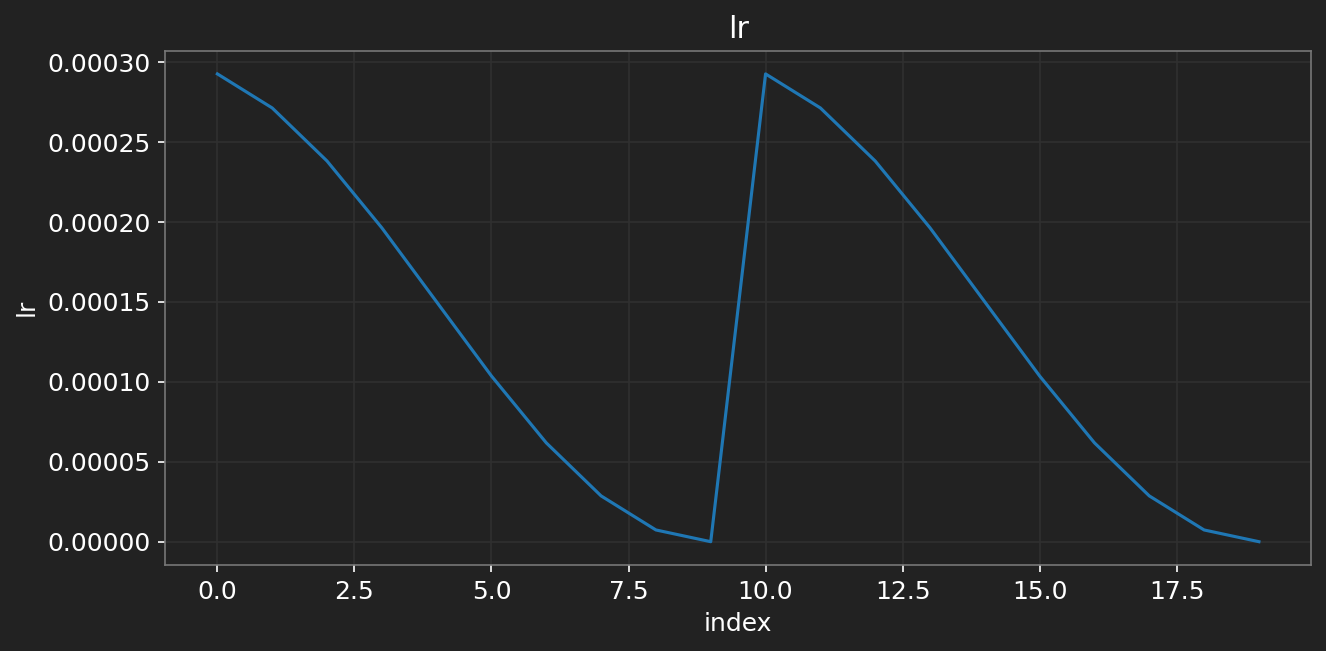

{'x_col': None,
 'plotted': ['reward', 'step_count', 'lr'],
 'saved': ['C:\\Users\\werna\\Documents\\GitHub\\AgentsLab\\runs\\PPO_CartPole-v1_20250827_164807\\figures\\reward.png',
  'C:\\Users\\werna\\Documents\\GitHub\\AgentsLab\\runs\\PPO_CartPole-v1_20250827_164807\\figures\\step_count.png',
  'C:\\Users\\werna\\Documents\\GitHub\\AgentsLab\\runs\\PPO_CartPole-v1_20250827_164807\\figures\\lr.png'],
 'figures': [<Figure size 1350x675 with 1 Axes>,
  <Figure size 1350x675 with 1 Axes>,
  <Figure size 1350x675 with 1 Axes>]}

In [13]:
from agentslab.utils.plotters import plot_metrics_from_csv

plot_metrics_from_csv(
    pathCfg.csv_train,
    style="ordevoir-dark",          # опционально; если стиля нет — просто предупредит
    x_candidates=("step"),
    include=("step_count", "reward","lr"),                   # можно передать список regex для фильтра
    exclude=None,                   # или исключить по regex
    ema=None,                       # например, ema=0.1 для сглаживания кривых
    downsample=None,                # например, downsample=10 для больших CSV
    save_dir=pathCfg.fig_dirs,                  # например, "figs" чтобы сохранять PNG
    show=True,                      # False — не показывать, только сохранять
    dpi=120,                        # DPI для сохранений
)

# Load 

In [14]:
# chkptr.load(pathCfg.ckpt_dir /"step_100000.pt", strict=False, map_location=genCfg.device)
chkptr.load(pathCfg.ckpt_dir / "best.pt", strict=False, map_location=genCfg.device)
collector.update_policy_weights_()  # чтобы коллектор увидел загруженные веса

# Evaluating

In [15]:
from agentslab.runners.evals import eval_policy

eval_policy(env, actor, episodes=10)

eval:   0%|          | 0/10 [00:00<?, ?it/s]

{'return_mean': 483.8,
 'return_sum': 4838.0,
 'max_episode_length': 499,
 'num_episodes': 10}

# Play Episode (Render)

## Make Env and Load

In [16]:
from dataclasses import replace

env_play = make_gym_env(replace(env_cfg, 
                                render_mode="rgb_array",
                                init_norm_iter = 1000,
                                # loc=env.transform[1].loc,
                                # scale=env.transform[1].scale
                                ))
env_play.transform[1].loc, env_play.transform[1].scale

(tensor([ 0.0290,  0.0575,  0.0176, -0.0729]),
 tensor([15.1060,  1.8941, 10.7838,  1.2710]))

In [17]:
statefuls_play = {
    "policy": actor,   # свежий инстанс сети под загрузку весов
    # если нужно — добавь optimizer/scheduler, либо опускай их на плейбэке
}
chkptr_play = CheckpointManager(
    ckpt_dir=pathCfg.ckpt_dir,
    statefuls=statefuls_play,
)
chkptr_play.register_obs_norms_from_env(env_play, prefix="obs_norm")
chkptr_play.load("best", strict=False, map_location="cpu") 

env_play.transform[1].loc, env_play.transform[1].scale

(tensor([0.0027, 0.0026, 0.0730, 0.0175]),
 tensor([12.4930,  1.8145, 10.7819,  1.2542]))

## Play

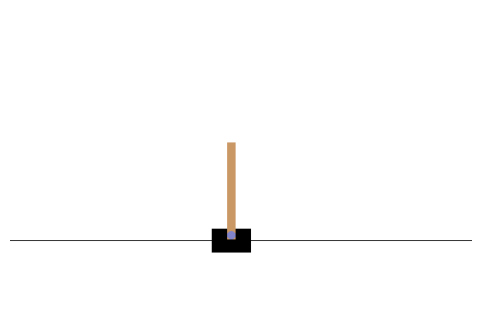

{'steps': 500, 'return': 500.0, 'terminated': False, 'truncated': True}

In [19]:
from agentslab.envs.gym_envs import play

play(
    actor,              # твой обученный актёр/policy
    env_play,           # среда с render_mode="rgb_array" или "human"
    fps=60,
    exp_type=None,      # авто: MODE для дискретных, DETERMINISTIC для непрерывных
    figsize=(6, 4),
    return_frames=False 
)